### Import packages

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import contextily as ctx

### Read the GeoJSON file

In [2]:
filepath = "./data/nyc_hex_bins.geojson"
map_df = gpd.read_file(filepath)[['hex_id', 'geometry']]

In [3]:
map_df.head()

,hex_id,geometry
0,0,"MULTIPOLYGON (((-73.96000 40.58774, -73.95333 ..."
1,1,"MULTIPOLYGON (((-73.96000 40.61084, -73.95333 ..."
2,2,"MULTIPOLYGON (((-73.96000 40.63393, -73.95333 ..."
3,3,"MULTIPOLYGON (((-73.96000 40.65702, -73.95333 ..."
4,4,"MULTIPOLYGON (((-73.96000 40.68012, -73.95333 ..."


### Visualize the GeoJSON file

In [4]:
map_df = map_df.to_crs(epsg=3857)

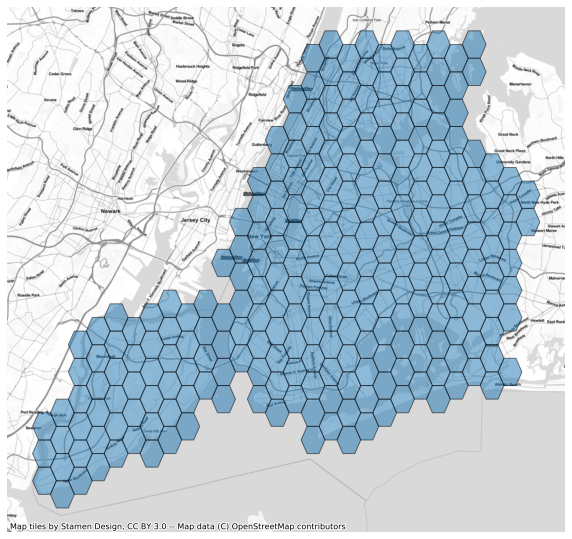

In [5]:
ax = map_df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, zoom=12, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

### Read data

In [6]:
filepath = "./data/data.csv"
df = pd.read_csv(filepath, header=0, index_col=False)

In [7]:
df.tail()

,timestep,wait_probability,hex_id
72283,287,0.281947,246
72284,287,0.288167,247
72285,287,0.018318,248
72286,287,0.016260,249
72287,287,0.279042,250


### Project data onto GeoJSON

Initially, we project data from a single timestep onto the GeoJSON for the purpose of this tutorial. Later, we will iterate through all the timesteps in order to create an animated gif.

In [8]:
def plot_choropleth(timestep):
    # Get subset of dataframe
    merged = map_df.set_index('hex_id').join(df[df.timestep == timestep].set_index('hex_id'))
    merged = merged.to_crs(epsg=3857)
    
    # set the range for the choropleth
    vmin, vmax = df['wait_probability'].describe()['min'], df['wait_probability'].describe()['max']

    # create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(15, 10))

    # create map
    ax2 = merged.plot(column='wait_probability', cmap='YlGnBu', linewidth=0.8, ax=ax, edgecolor='0.8', alpha=0.6)
    ctx.add_basemap(ax2, zoom=11, source=ctx.providers.Stamen.TonerLite)

    # Remove axis labels
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

    # add a title
    ax.set_title('Wait probability\nTimestep:{}'.format(timestep), fontdict={'fontsize': '20', 'fontweight' : '3'})

    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(cmap='YlGnBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm)
    
    return ax, fig

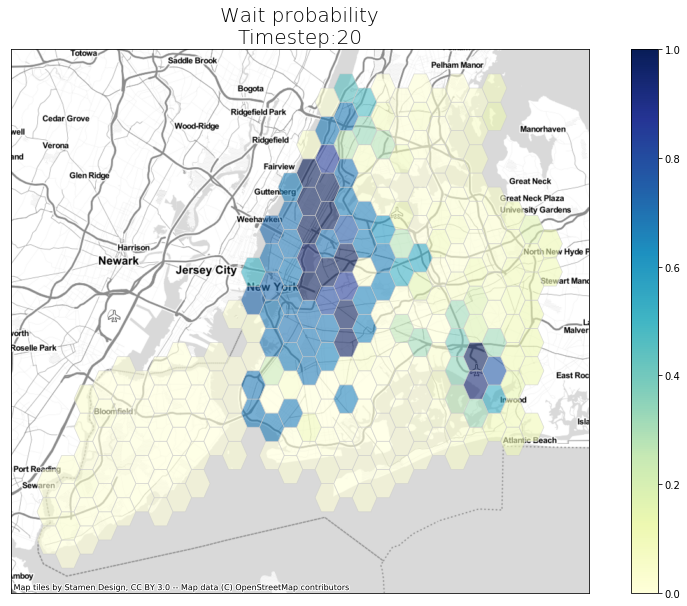

In [9]:
ax, fig = plot_choropleth(20)

### Export all timesteps for the animations

In [10]:
total_timesteps = int(df.describe()['timestep']['max'])

In [11]:
for i in range(100):
    ax, fig = plot_choropleth(i)
    fig.savefig('./viz/img{:03d}.png'.format(i), dpi=100, format='png', bbox_inches='tight')
    plt.close()

In [12]:
%%bash
cd viz;

# Create a gif viz
ffmpeg -framerate 2 -i img%03d.png -f gif out.gif


ffmpeg version 2.8.15 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 4.8.5 (GCC) 20150623 (Red Hat 4.8.5-36)
  configuration: --prefix=/usr --bindir=/usr/bin --datadir=/usr/share/ffmpeg --incdir=/usr/include/ffmpeg --libdir=/usr/lib64 --mandir=/usr/share/man --arch=x86_64 --optflags='-O2 -g -pipe -Wall -Wp,-D_FORTIFY_SOURCE=2 -fexceptions -fstack-protector-strong --param=ssp-buffer-size=4 -grecord-gcc-switches -m64 -mtune=generic' --extra-ldflags='-Wl,-z,relro ' --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libvo-amrwbenc --enable-version3 --enable-bzlib --disable-crystalhd --enable-gnutls --enable-ladspa --enable-libass --enable-libcdio --enable-libdc1394 --enable-libfdk-aac --enable-nonfree --disable-indev=jack --enable-libfreetype --enable-libgsm --enable-libmp3lame --enable-openal --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-libschroedinger --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libvorbis --enable-libv4l2 

In [13]:
%%bash
cd viz;

# Create mp4 video
ffmpeg -framerate 2 -i img%03d.png -c:v libx264 -pix_fmt yuv420p -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" out.mp4

ffmpeg version 2.8.15 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 4.8.5 (GCC) 20150623 (Red Hat 4.8.5-36)
  configuration: --prefix=/usr --bindir=/usr/bin --datadir=/usr/share/ffmpeg --incdir=/usr/include/ffmpeg --libdir=/usr/lib64 --mandir=/usr/share/man --arch=x86_64 --optflags='-O2 -g -pipe -Wall -Wp,-D_FORTIFY_SOURCE=2 -fexceptions -fstack-protector-strong --param=ssp-buffer-size=4 -grecord-gcc-switches -m64 -mtune=generic' --extra-ldflags='-Wl,-z,relro ' --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libvo-amrwbenc --enable-version3 --enable-bzlib --disable-crystalhd --enable-gnutls --enable-ladspa --enable-libass --enable-libcdio --enable-libdc1394 --enable-libfdk-aac --enable-nonfree --disable-indev=jack --enable-libfreetype --enable-libgsm --enable-libmp3lame --enable-openal --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-libschroedinger --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libvorbis --enable-libv4l2 